In [1]:
# Web Traffic Forecasting


## Understanding the Problem Statement
#In order to dynamically manage resources to run your website, you need to have an idea about the number of visitors who might arrive at your website at different points in time. So, the problem at hand is to predict the web traffic or number of sessions in the next hour based on the historical data.

## Load Dataset

#Let us load the dataset first.

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt


data=pd.read_csv('/Users/paramanandbhat/Downloads/web_traffic/webtraffic.csv')


print(data.shape)


(4896, 2)


In [2]:
#Glance the first 5 rows
print(data.head())



   Hour Index    Sessions
0           0  1418159421
1           1  1113769116
2           2   919158921
3           3   822352824
4           4   735526737


In [3]:
## Data Exploration
sessions = data['Sessions'].values


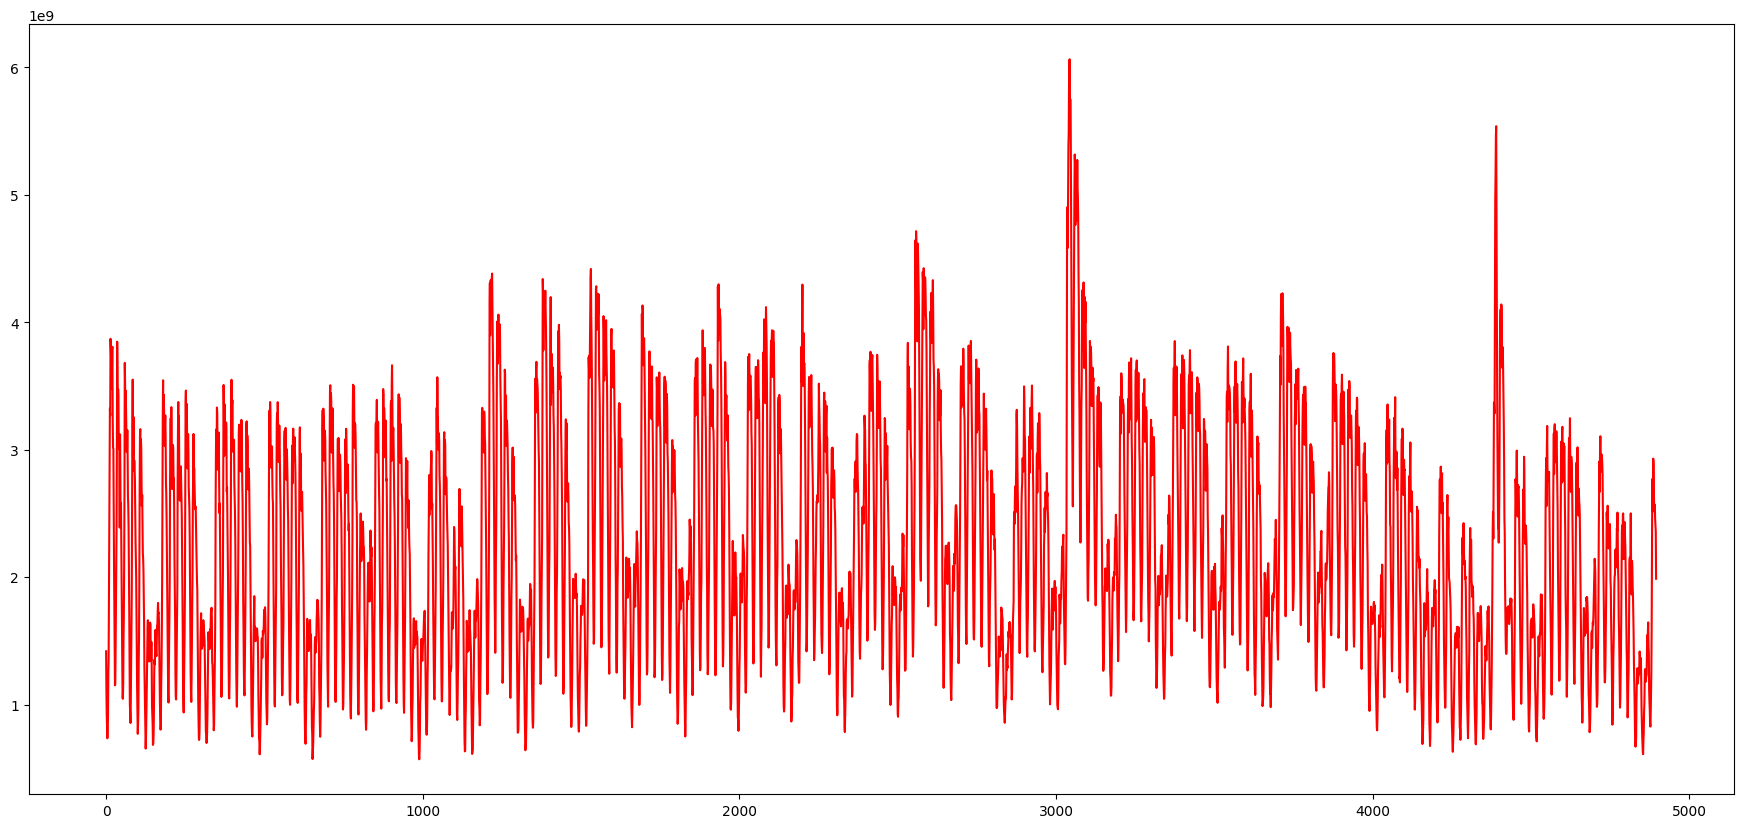

In [4]:
# plot entire data
ar = np.arange(len(sessions))
plt.figure(figsize=(22,10))
plt.plot(ar, sessions,'r')
plt.show()


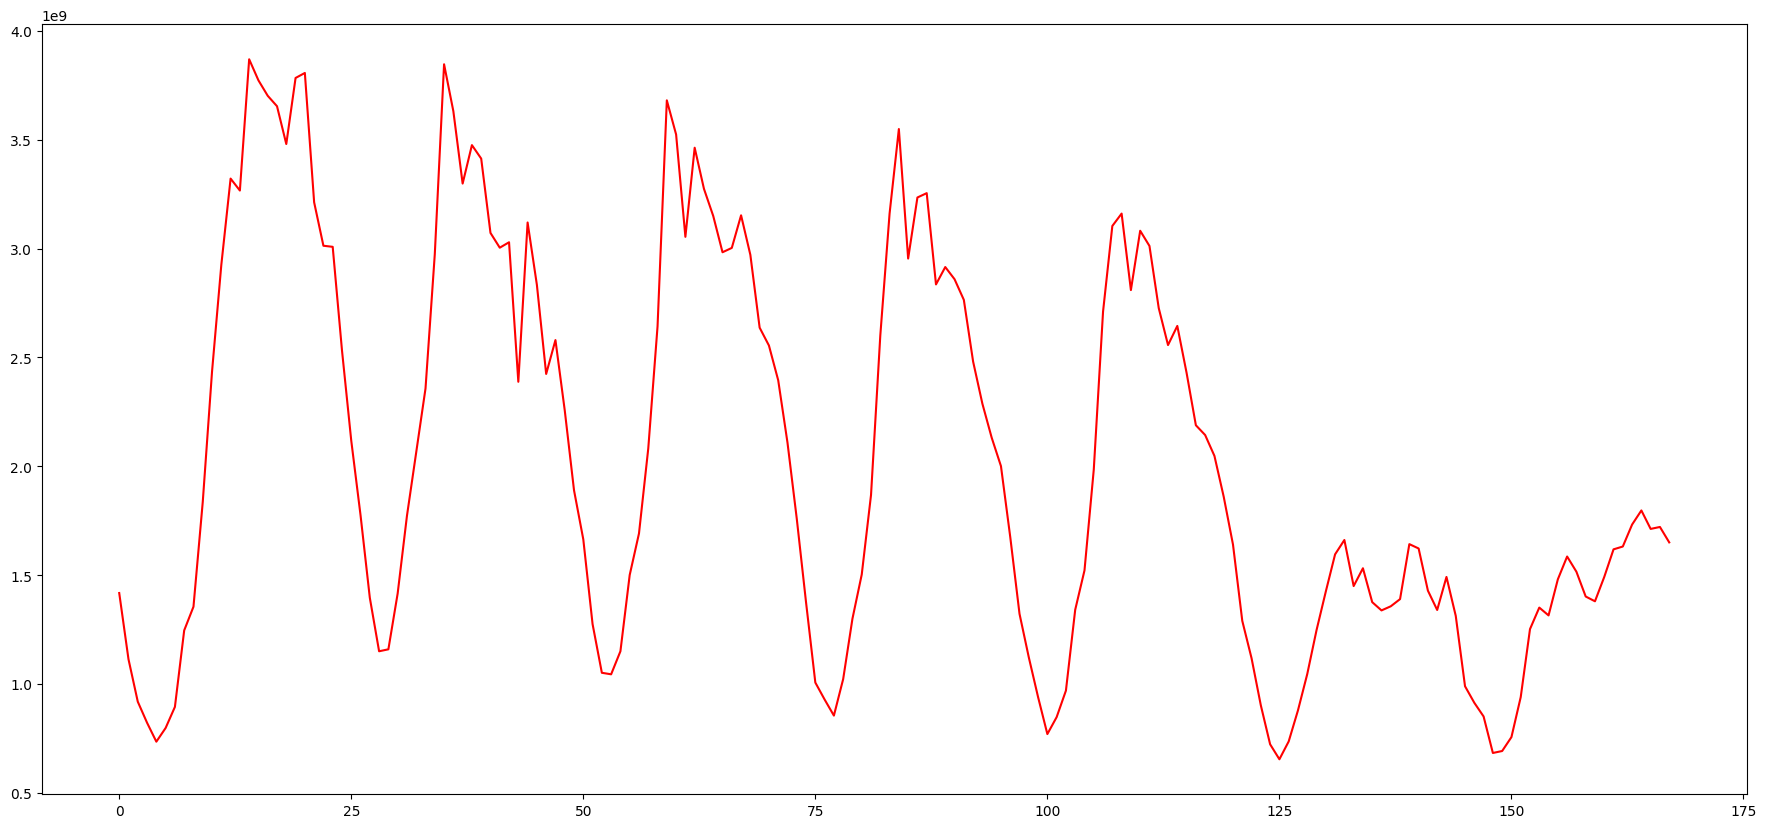

In [5]:
# first week web traffic
sample = sessions[:168]
ar = np.arange(len(sample))
plt.figure(figsize=(22,10))
plt.plot(ar, sample,'r')
plt.show()


In [6]:
## Data Preparation

#We will model the problem to predict the 
#traffic for the next hour based on the previous
# week data i.e. 168 hours. Lets define a 
#function to prepare the input and output data 
#accordingly.

#*Note: The input is a sequence of values and
# the output is a single value.*
def prepare_data(seq,num):
  x=[]
  y=[]

  for i in range(0,(len(seq)-num),1):
    
    input_ = seq[i:i+num]
    output  = seq[i+num]
    
    x.append(input_)
    y.append(output)
    
  return np.array(x), np.array(y)



In [7]:
#Call the function
x,y= prepare_data(sessions,168)

print(len(x))

print(x[0])
print(y[0])



4728
[1418159421 1113769116  919158921  822352824  735526737  798400800
  895206897 1246503249 1355285358 1836321840 2435122440 2925140931
 3321347328 3266457273 3869249877 3772443780 3701585709 3653681661
 3480029487 3783421791 3806375814 3212565219 3012965019 3007975014
 2532926538 2117758122 1775443779 1396203399 1150695153 1159677162
 1416163419 1772449776 2063866068 2357278362 2974042980 3846295854
 3630727638 3298393305 3475039482 3413163420 3071847078 3003983010
 3028933035 2388216393 3119751126 2833324839 2424144429 2579832585
 2257478262 1890213894 1664665668 1275445278 1051893054 1044907047
 1150695153 1500993504 1691611695 2081830086 2642706648 3680627688
 3523941531 3053883060 3463063470 3274441281 3149691156 2983024989
 3002985009 3152685159 2971048977 2636718642 2554882560 2395202400
 2108776113 1759475763 1375245378 1006983009  929138931  855286857
 1022951025 1300395303 1502989506 1868257872 2600790606 3160669167
 3548891556 2954082960 3234521241 3254481261 2835320841 2

In [8]:
#Split the dataset into training and validation data
ind = int(0.9 * len(x))

# training set
x_tr = x[:ind]
y_tr = y[:ind]

# validation set
x_val=x[ind:]
y_val=y[ind:]


In [9]:
#Normalize the input and output data as it speeds up the training process
from sklearn.preprocessing import StandardScaler

#normalize the inputs
x_scaler= StandardScaler()
x_tr = x_scaler.fit_transform(x_tr)
x_val= x_scaler.transform(x_val)

#reshaping the output for normalization
y_tr=y_tr.reshape(len(y_tr),1)
y_val=y_val.reshape(len(y_val),1)



In [10]:
#normalize the output
y_scaler=StandardScaler()
y_tr = y_scaler.fit_transform(y_tr)[:,0]
y_val = y_scaler.transform(y_val)[:,0]



print(x_tr.shape)
'''
As you can see here, the input data is a 2 dimenional array but the LSTM accepts only 3 dimensional inputs in the form of (no. of samples, no. of timesteps, no. of features)

So, reshaping the input data as per the model requirement

'''

#reshaping input data
x_tr= x_tr.reshape(x_tr.shape[0],x_tr.shape[1],1)
x_val= x_val.reshape(x_val.shape[0],x_val.shape[1],1)
print(x_tr.shape)


(4255, 168)
(4255, 168, 1)


In [11]:
#Now, the data is ready for model training. 
## Model Building

#Define the model architecture
from keras.models import *
from keras.layers import *
from keras.callbacks import *

# define model
model =  Sequential()
model.add(LSTM(128,input_shape=(168,1)))
model.add(Dense(64,activation='relu'))
model.add(Dense(1,activation='linear'))

#Understand the output shape and no. of parameters of each layer

print(model.summary())

#Define the optimizer and loss:

model.compile(loss='mse',optimizer='adam')

mc = ModelCheckpoint('best_model.hdf5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history=model.fit(x_tr, y_tr ,epochs=30, batch_size=32, validation_data=(x_val,y_val), callbacks=[mc])

#Load the weights of best model prior to predictions

model.load_weights('best_model.hdf5')

#Evaluate the performance of model on the validation data
mse = model.evaluate(x_val,y_val)
print("Mean Square Error:",mse)


## Comparision with Baseline Model

# build a simple moving average model
def compute_moving_average(data):
  pred=[]
  for i in data:
    avg=np.sum(i)/len(i)
    pred.append(avg)
  return np.array(pred)

# reshape the data
x_reshaped = x_val.reshape(-1,168)

# get predictions
y_pred = compute_moving_average(x_reshaped)

# evaluate the performance of model on the validation data
mse = np.sum ( (y_val - y_pred) **2 ) / (len(y_val))
print(mse)




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 74881 (292.50 KB)
Trainable params: 74881 (292.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/30
133/133 [==============================] - ETA: 0s - loss: 0.1606
Epoch 1: val_loss improved from inf to 0.03702, saving model to best_model.hdf5
133/133 [==============================] - 11s 78ms/step - loss: 0.1606 - val_loss: 0.0370
Epoch 2/30
  2/133 [.........

/Users/paramanandbhat/Projects/Param_learn/ML/miniconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


133/133 [==============================] - ETA: 0s - loss: 0.0422
Epoch 2: val_loss improved from 0.03702 to 0.02915, saving model to best_model.hdf5
133/133 [==============================] - 10s 76ms/step - loss: 0.0422 - val_loss: 0.0292
Epoch 3/30
133/133 [==============================] - ETA: 0s - loss: 0.0381
Epoch 3: val_loss did not improve from 0.02915
133/133 [==============================] - 10s 76ms/step - loss: 0.0381 - val_loss: 0.0339
Epoch 4/30
133/133 [==============================] - ETA: 0s - loss: 0.0329
Epoch 4: val_loss improved from 0.02915 to 0.02515, saving model to best_model.hdf5
133/133 [==============================] - 10s 76ms/step - loss: 0.0329 - val_loss: 0.0252
Epoch 5/30
133/133 [==============================] - ETA: 0s - loss: 0.0319
Epoch 5: val_loss improved from 0.02515 to 0.02442, saving model to best_model.hdf5
133/133 [==============================] - 11s 82ms/step - loss: 0.0319 - val_loss: 0.0244
Epoch 6/30
133/133 [====================

1/1 [==============================] - 0s 27ms/step


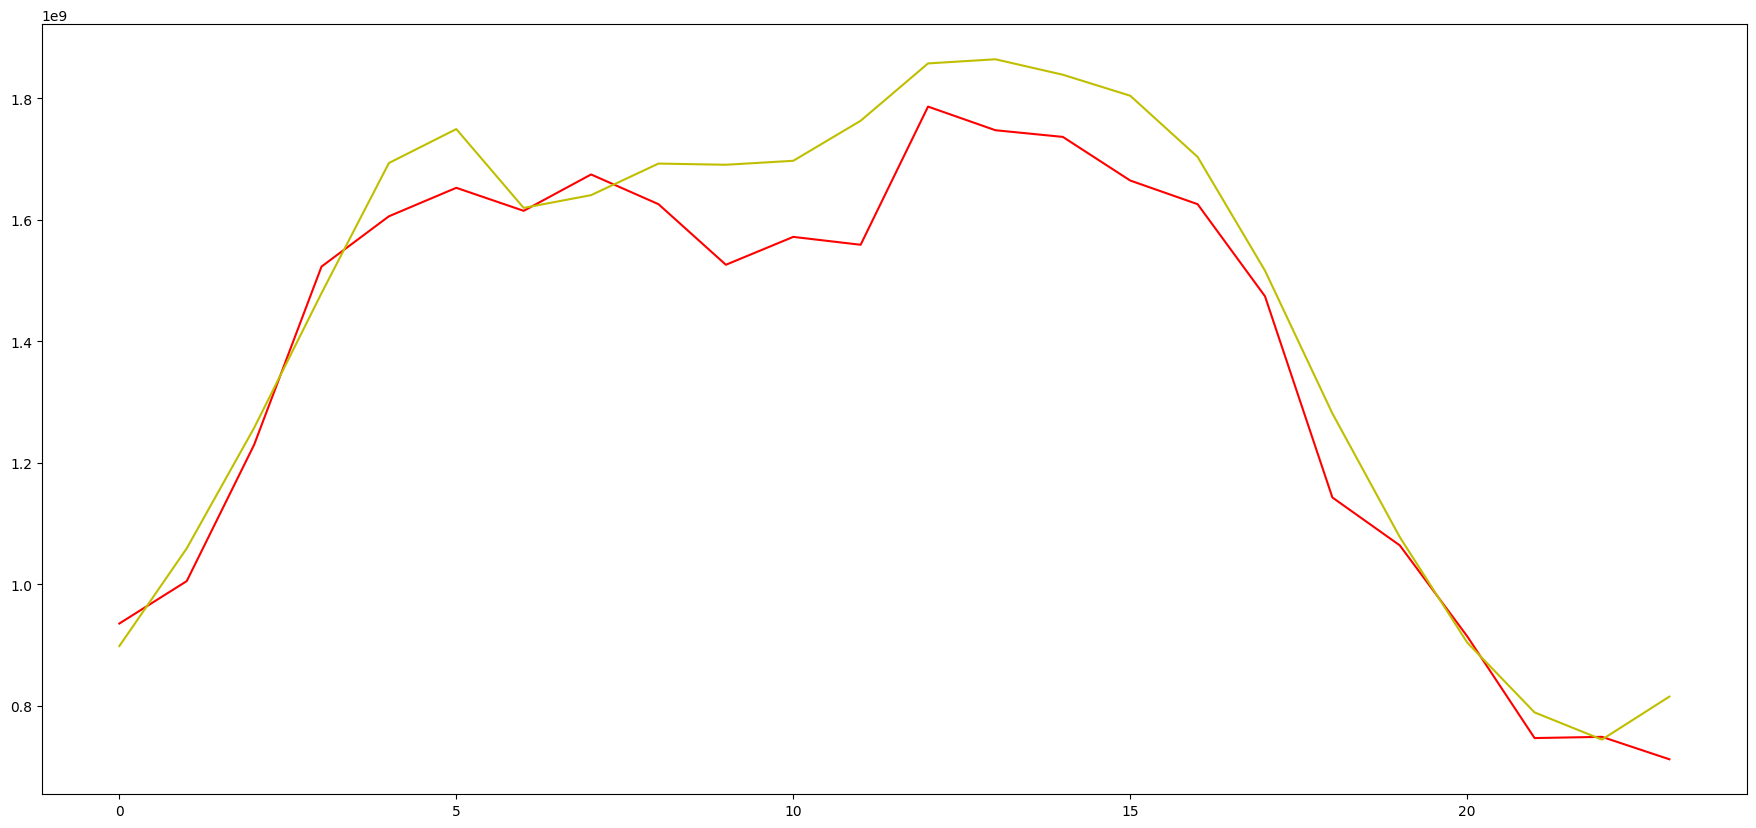

In [12]:
# Forecasting

'''
**Steps to Follow**:
1. Intialize the array, say "data" with a weeks data
2. Predict for the next hour
3. Append the predicted value as the last element of array "data"
4. Skip the first element of array "data"
5. Repeat steps 2 to 4 for **N** iterations
Define a function which forecasts the traffic for the next hours from the previous week data.
'''
def forecast(x_val, no_of_pred, ind):
  predictions=[]

  #intialize the array with a weeks data
  temp=x_val[ind]

  for i in range(no_of_pred): 

    #predict for the next hour
    pred=model.predict(temp.reshape(1,-1,1))[0][0]
    
    #append the prediction as the last element of array
    temp = np.insert(temp,len(temp),pred)
    predictions.append(pred)

    #ignore the first element of array
    temp = temp[1:]

  return predictions

#Its time to forecast the traffic for the next 24 hours based on the previous week data
no_of_pred =24
ind=72
y_pred= forecast(x_val,no_of_pred,ind)

y_true = y_val[ind:ind+(no_of_pred)]

#Lets convert back the normalized values to the original dimensional space
y_true = y_scaler.inverse_transform(y_true.reshape(-1, 1))

y_pred = y_scaler.inverse_transform(np.array(y_pred).reshape(-1, 1))


def plot(y_true,y_pred):
  ar = np.arange(len(y_true))
  plt.figure(figsize=(22,10))
  plt.plot(ar, y_true,'r')
  plt.plot(ar, y_pred,'y')
  plt.show()


plot(y_true,y_pred)




